In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from collections import Counter
import re
import nltk
import pymorphy2
from ast import literal_eval
#import gensim

In [2]:
data=pd.read_csv("kinopoisk.csv")
data

,review,type
0,Это моё мнение и мне без разницы сколько будет...,1
1,"Вполне неплохое шоу, выгодно отличающееся от б...",1
2,"Уж кто-кто, а российские специалисты 'умеют' с...",0
3,"Нью-йоркский маргинал и, по совместительству –...",1
4,"Есть такая категория фильмов, которые построен...",1
...,...,...
131664,"Придя из кинотеатра, необходимо было переварит...",1
131665,Молодой парень Адонис Джонсон вырос в приёмной...,0
131666,На дворе 21 век. Мировой кинематограф заражён ...,-1
131667,"Ну и ничего, что 70 % времени уделено молодому...",1


In [3]:
data["type"].value_counts()

 1    87138
 0    24704
-1    19827
Name: type, dtype: int64

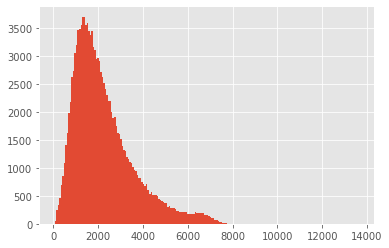

In [4]:
data.review.str.len().hist(bins=200);

Отличаются ли рецензии разной тональности длиной?

<AxesSubplot:>

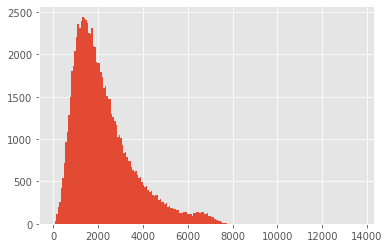

In [5]:
pos_data=data[data["type"]==1]
pos_data.review.str.len().hist(bins=200)

<AxesSubplot:>

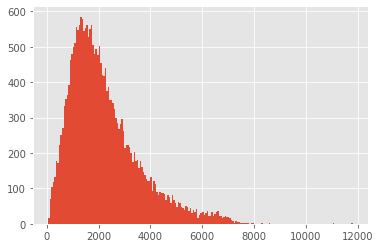

In [6]:
neu_data=data[data["type"]==0]
neu_data.review.str.len().hist(bins=200)

<AxesSubplot:>

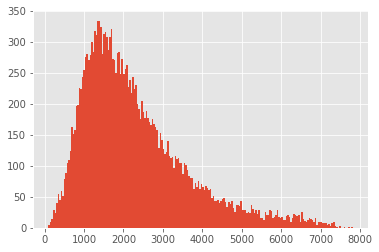

In [7]:
neg_data=data[data["type"]==-1]
neg_data.review.str.len().hist(bins=200)

Посмотрим на самые частые слова/сочетания слов.

In [8]:
pipe = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern="[а-яё]+",
            min_df=3, max_df=0.7
        )
    ),
    ('clf', SGDClassifier(random_state=43, loss='log', class_weight='balanced'))
])

In [9]:
x=data["review"].values
y=data["type"].values

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [11]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, min_df=3,
                                 token_pattern='[а-яё]+')),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=43))])

In [12]:
test_predictions = pipe.predict(x_test)

In [14]:
from sklearn.metrics import confusion_matrix
m=confusion_matrix(y_true=y_test, y_pred=test_predictions)
m

array([[ 3529,  1484,   879],
       [ 1209,  2854,  3350],
       [  651,  3010, 22535]], dtype=int64)

In [15]:
def our_precision(m):
    a1, a2, a3, b1, b2, b3, c1, c2, c3 = m[0][0], m[0][1], m[0][2], m[1][0], m[1][1], m[1][2], m[2][0], m[2][1], m[2][2]
    error = 0
    return [c3/(c3+a3+b3), b2/(a2+c2+b2), a1/(a1+b1+c1)]


In [16]:
print("Precision для положительных отзывов: ", our_precision(m)[0])
print("Precision для нейтральных отзывов: ", our_precision(m)[1])
print("Precision для отрицательных отзывов: ", our_precision(m)[2])

Precision для положительных отзывов:  0.8419892392766403
Precision для нейтральных отзывов:  0.38840500816548723
Precision для отрицательных отзывов:  0.6548524772685099


In [17]:
def our_recall(m):
    a1, a2, a3, b1, b2, b3, c1, c2, c3 = m[0][0], m[0][1], m[0][2], m[1][0], m[1][1], m[1][2], m[2][0], m[2][1], m[2][2]
    error = 0
    return [c3/(c3+c2+c1), b2/(b1+b2+b3),a1/(a1+a2+a3)]

In [18]:
 
print("Recall для положительных отзывов: ", our_recall(m)[0])
print("Recall для нейтральных отзывов: ", our_recall(m)[1])
print("Recall для отрицательных отзывов: ", our_recall(m)[2])

Recall для положительных отзывов:  0.8602458390593983
Recall для нейтральных отзывов:  0.38499932550924054
Recall для отрицательных отзывов:  0.5989477257298031


In [19]:
def our_F1score(m):
    a1, a2, a3, b1, b2, b3, c1, c2, c3 = m[0][0], m[0][1], m[0][2], m[1][0], m[1][1], m[1][2], m[2][0], m[2][1], m[2][2]
    error = 0
    return [2*((our_precision(m)[0] * our_recall(m)[0])/(our_precision(m)[0] + our_recall(m)[0])), 2*((our_precision(m)[2] * our_recall(m)[2])/(our_precision(m)[2] + our_recall(m)[2])), 2*((our_precision(m)[1] * our_recall(m)[1])/(our_precision(m)[1] + our_recall(m)[1]))]

In [20]:
print("F1score для положительных отзывов: ", our_F1score(m)[0])
print("F1score для нейтральных отзывов: ", our_F1score(m)[1])
print("F1score для отрицательных отзывов: ", our_F1score(m)[2])

F1score для положительных отзывов:  0.8510196374622357
F1score для нейтральных отзывов:  0.6256537540998138
F1score для отрицательных отзывов:  0.38669466838290084


In [22]:
a1=m[0][0]
a2=m[0][1]
a3=m[0][2]
b1=m[1][0]
b2=m[1][1]
b3=m[1][2]
c1=m[2][0]
c2=m[2][1]
c3=m[2][2]

In [23]:
(a1+b2+c3)/(a1+b2+c3+a2+b1+b3+c2+2*c1+2*a3)

0.7047841875654992

In [24]:
balanced_accuracy_score(test_predictions,y_test)

0.6284155749035457

In [33]:
balanced_accuracy_score(y_test, test_predictions)

0.617695134217287

In [34]:
from sklearn.metrics import confusion_matrix
m=confusion_matrix(y_true=y_test, y_pred=test_predictions)
m

array([[ 3951,  1133,   836],
       [ 1561,  2336,  3484],
       [  913,  2514, 22773]], dtype=int64)

In [39]:
accuracy_score(y_test, test_predictions)

0.7356775777828409